In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import multiprocessing
import optuna
import cma

In [2]:
m = pd.read_csv("../../data/processed/processed_3.csv")

In [3]:
m

,감독,제작사,배급사,전국 스크린수,전국 관객수,개봉년,국적_기타,국적_독일,국적_러시아,국적_미국,...,장르_어드벤처,장르_전쟁,장르_코미디,장르_판타지,등급_12세이상관람가,등급_15세이상관람가,등급_전체관람가,등급_청소년관람불가,영화구분_독립/예술영화,영화구분_일반영화
0,14.306190,12.886638,13.649190,1587.0,17613682.0,2014,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
1,15.172542,16.604523,13.649190,1978.0,16264944.0,2019,False,False,False,False,...,False,False,True,False,False,True,False,False,False,True
2,15.714698,16.402393,12.997266,1912.0,14410754.0,2017,False,False,False,False,...,False,False,False,True,True,False,False,False,False,True
3,15.908342,15.263750,13.649190,966.0,14245998.0,2014,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,14.740589,15.240150,13.427532,2835.0,13934592.0,2019,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,9.341284,8.692994,9.155124,166.0,5960.0,2020,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
2288,9.140915,9.140915,9.540295,91.0,6876.0,2021,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
2289,8.068090,10.300064,8.068090,65.0,3190.0,2021,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2290,12.487732,12.141428,13.049010,699.0,360873.0,2021,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


In [4]:
# 변수 제거 함수
def recursive_feature_elimination(X, y, model, min_features=1, verbose=True):
    # 초기 변수 개수
    n_features = X.shape[1]
    
    # 현재 변수들의 성능
    best_score = float("inf")
    best_features = X.columns.tolist()
    
    # 최소 변수 개수 이상인 경우
    while n_features > min_features:
        # 모든 변수에 대해 반복
        scores = []
        for feature in X.columns:
            # 선택한 변수 제외
            features = X.columns.drop(feature)
            X_new = X[features]
            
            # 모델 학습 및 평가
            model.fit(X_new, y)
            y_pred = model.predict(X_new)
            score = mean_squared_error(y, y_pred)
            scores.append(score)
            
        # 가장 성능이 좋은 변수 선택
        idx = pd.Index(scores).argmin()
        worst_feature = X.columns[idx]
        
        # 변수 제거
        X.drop(worst_feature, axis=1, inplace=True)
        n_features = X.shape[1]
        if verbose:
            print(f"Removing {worst_feature}: {n_features} features left")
        
        # 현재 변수 개수에서의 성능이 최선인 경우
        if min(scores) < best_score:
            best_score = min(scores)
            best_features = X.columns.tolist()
        else:
            break
    
    # 최종 선택된 변수들
    return best_features

# ElasticNetCV 모델 객체 생성
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
enet = ElasticNetCV(alphas=alphas, l1_ratio=0.5, cv=5, max_iter=10000)

# 최소 변수 개수 지정
min_features = 5

# 재귀적 변수 제거 수행
X = m.drop("전국 관객수", axis=1)
y = m["전국 관객수"]
selected_features = recursive_feature_elimination(X, y, enet, min_features=min_features)

# 선택된 변수 출력
print(f"{len(selected_features)} features selected:")
print(selected_features)

Removing 국적_프랑스: 41 features left
Removing 국적_중국: 40 features left
41 features selected:
['감독', '제작사', '배급사', '전국 스크린수', '개봉년', '국적_기타', '국적_독일', '국적_러시아', '국적_미국', '국적_스페인', '국적_영국', '국적_일본', '국적_중국', '국적_캐나다', '국적_한국', '장르_SF', '장르_가족', '장르_공연', '장르_공포(호러)', '장르_기타', '장르_다큐멘터리', '장르_드라마', '장르_멜로/로맨스', '장르_뮤지컬', '장르_미스터리', '장르_범죄', '장르_사극', '장르_서부극(웨스턴)', '장르_스릴러', '장르_애니메이션', '장르_액션', '장르_어드벤처', '장르_전쟁', '장르_코미디', '장르_판타지', '등급_12세이상관람가', '등급_15세이상관람가', '등급_전체관람가', '등급_청소년관람불가', '영화구분_독립/예술영화', '영화구분_일반영화']


In [5]:
# 데이터 분할
X = m[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# KNeighborsRegressor 모델 학습
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

# KNeighborsRegressor 모델 예측
knn_y_pred = knn.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, knn_y_pred, squared=False)
mae = mean_absolute_error(y_test, knn_y_pred)
r2 = r2_score(y_test, knn_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 1333611.8592063787
MAE: 573433.5639534884
R-squared: 0.3969621029041389


In [21]:
# RandomForestRegressor 모델 학습
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# RandomForestRegressor 모델 예측
rf_y_pred = rf.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
mae = mean_absolute_error(y_test, rf_y_pred)
r2 = r2_score(y_test, rf_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 710730.9129839207
MAE: 296130.8933946221
R-squared: 0.8287241550573674


In [22]:
# GradientBoostingRegressor 모델 학습
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

# GradientBoostingRegressor 모델 예측
gb_y_pred = gb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, gb_y_pred, squared=False)
mae = mean_absolute_error(y_test, gb_y_pred)
r2 = r2_score(y_test, gb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 737017.6109481017
MAE: 323099.18514413445
R-squared: 0.8158204367431859


In [9]:
# XGBRegressor 모델 학습
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)

# XGBRegressor 모델 예측
xgb_y_pred = xgb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, xgb_y_pred, squared=False)
mae = mean_absolute_error(y_test, xgb_y_pred)
r2 = r2_score(y_test, xgb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 788092.1349453557
MAE: 322066.73794990365
R-squared: 0.789409054409296


In [10]:
# LGBMRegressor 모델 학습
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

# LGBMRegressor 모델 예측
lgbm_y_pred = lgbm.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, lgbm_y_pred, squared=False)
mae = mean_absolute_error(y_test, lgbm_y_pred)
r2 = r2_score(y_test, lgbm_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 804103.8163089625
MAE: 325783.2773282595
R-squared: 0.7807649667541882


In [39]:
# ExtraTreesRegressor 모델 학습
et = ExtraTreesRegressor(random_state=42)
et.fit(X_train, y_train)

# ExtraTreesRegressor 모델 예측
et_y_pred = et.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, et_y_pred, squared=False)
mae = mean_absolute_error(y_test, et_y_pred)
r2 = r2_score(y_test, et_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 643614.4590544587
MAE: 279615.801184593
R-squared: 0.859544971479825


In [46]:
# SVR 모델 학습
svr = SVR(kernel="linear", C=1.0, epsilon=0.1)
svr.fit(X_train, y_train)

# ExtraTreesRegressor 모델 예측
svr_y_pred = svr.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, svr_y_pred, squared=False)
mae = mean_absolute_error(y_test, svr_y_pred)
r2 = r2_score(y_test, svr_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 1430832.5544243113
MAE: 641698.3532574554
R-squared: 0.3058340077996927


In [11]:
def optimize_model(model_objective, n_trials=100):
    # Bayesian optimization 방식의 하이퍼파라미터 튜닝을 위해 Optuna 라이브러리 사용
    # 최소화를 목적으로 하기 때문에 'minimize'로 설정
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.CmaEsSampler())
    
    # 사용 가능한 모든 CPU 코어 수를 사용하여 병렬 처리
    n_jobs = multiprocessing.cpu_count()  
    
    # 모델 하이퍼파라미터 최적화 실행
    study.optimize(model_objective, n_trials=n_trials, n_jobs=n_jobs)
    
    # 최적 하이퍼파라미터와 그 때의 평가지표 출력
    print(f"Best RMSE: {study.best_value:.4f}")
    print(f"Best Parameters: {study.best_params}")
    
    # 최적 하이퍼파라미터 반환
    return study.best_params

In [12]:
# Random Forest 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    score = cross_val_score(rf, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Random Forest 모델의 하이퍼파라미터 최적화
rf_params = optimize_model(rf_objective)

[I 2023-05-11 09:50:37,802] A new study created in memory with name: no-name-f66a4f98-4e57-40c0-aa59-31dde3852d0e
[I 2023-05-11 09:51:07,992] Trial 7 finished with value: 1857511.5518148984 and parameters: {'n_estimators': 600, 'max_depth': 3}. Best is trial 7 with value: 1857511.5518148984.
[I 2023-05-11 09:51:23,557] Trial 3 finished with value: 1833776.4843015042 and parameters: {'n_estimators': 700, 'max_depth': 4}. Best is trial 3 with value: 1833776.4843015042.
[I 2023-05-11 09:51:34,248] Trial 0 finished with value: 1836930.8005722323 and parameters: {'n_estimators': 400, 'max_depth': 10}. Best is trial 3 with value: 1833776.4843015042.
[I 2023-05-11 09:51:41,199] Trial 1 finished with value: 1828422.2181779123 and parameters: {'n_estimators': 800, 'max_depth': 5}. Best is trial 1 with value: 1828422.2181779123.
[I 2023-05-11 09:51:56,874] Trial 4 finished with value: 1828378.9399201695 and parameters: {'n_estimators': 1000, 'max_depth': 5}. Best is trial 4 with value: 1828378.9

Best RMSE: 1828067.3425
Best Parameters: {'n_estimators': 700, 'max_depth': 5}


RandomForestRegressor(max_depth=5, n_estimators=700, random_state=42)

In [13]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
rf.set_params(**rf_params)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
mae = mean_absolute_error(y_test, rf_y_pred)
r2 = r2_score(y_test, rf_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 750979.4917089096
MAE: 326022.93331947393
R-squared: 0.8087762360908739


In [14]:
# Gradient Boosting 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def gb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    gb = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                                   max_depth=max_depth, random_state=42)
    score = cross_val_score(gb, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Gradient Boosting 모델의 하이퍼파라미터 최적화
gb_params = optimize_model(gb_objective)

[I 2023-05-11 10:03:11,202] A new study created in memory with name: no-name-5ca1ae32-3409-4ab6-be9b-3f9ffee235f7
[I 2023-05-11 10:03:15,788] Trial 4 finished with value: 1774913.0209438733 and parameters: {'n_estimators': 100, 'learning_rate': 0.058633042466108135, 'max_depth': 3}. Best is trial 4 with value: 1774913.0209438733.
[I 2023-05-11 10:03:20,967] Trial 5 finished with value: 1804629.7334035686 and parameters: {'n_estimators': 100, 'learning_rate': 0.06787133359911496, 'max_depth': 6}. Best is trial 4 with value: 1774913.0209438733.
[I 2023-05-11 10:03:24,124] Trial 2 finished with value: 1829894.8739943171 and parameters: {'n_estimators': 100, 'learning_rate': 0.0675852557091261, 'max_depth': 8}. Best is trial 4 with value: 1774913.0209438733.
[I 2023-05-11 10:03:31,667] Trial 1 finished with value: 1761406.804650994 and parameters: {'n_estimators': 400, 'learning_rate': 0.06832297612486422, 'max_depth': 3}. Best is trial 1 with value: 1761406.804650994.
[I 2023-05-11 10:03:

Best RMSE: 1758694.9870
Best Parameters: {'n_estimators': 500, 'learning_rate': 0.023052027065024527, 'max_depth': 3}


GradientBoostingRegressor(learning_rate=0.023052027065024527, n_estimators=500,
                          random_state=42)

In [15]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
gb.set_params(**gb_params)
gb.fit(X_train, y_train)
gb_y_pred = gb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, gb_y_pred, squared=False)
mae = mean_absolute_error(y_test, gb_y_pred)
r2 = r2_score(y_test, gb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 746631.1382136827
MAE: 317989.14106054546
R-squared: 0.8109842889425339


In [16]:
# XGBoost 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def xgb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    xgb = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth=max_depth, subsample=subsample, random_state=42)
    score = cross_val_score(xgb, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# XGBoost 모델의 하이퍼파라미터 최적화
xgb_params = optimize_model(xgb_objective)

[I 2023-05-11 10:13:06,677] A new study created in memory with name: no-name-0bfbab41-973a-45eb-b3de-cdb8b0997e12
[I 2023-05-11 10:13:13,359] Trial 7 finished with value: 1820499.3651505748 and parameters: {'n_estimators': 100, 'learning_rate': 0.04629223928231461, 'max_depth': 6, 'subsample': 0.857211794268879}. Best is trial 7 with value: 1820499.3651505748.
[I 2023-05-11 10:13:17,701] Trial 5 finished with value: 1756325.0591028458 and parameters: {'n_estimators': 300, 'learning_rate': 0.05193069936754795, 'max_depth': 3, 'subsample': 0.8748593698421928}. Best is trial 5 with value: 1756325.0591028458.
[I 2023-05-11 10:13:23,078] Trial 0 finished with value: 1830635.2643931436 and parameters: {'n_estimators': 200, 'learning_rate': 0.02308668827016702, 'max_depth': 7, 'subsample': 0.6065681921672899}. Best is trial 5 with value: 1756325.0591028458.
[I 2023-05-11 10:13:37,133] Trial 8 finished with value: 1799898.277585477 and parameters: {'n_estimators': 400, 'learning_rate': 0.05481

Best RMSE: 1755225.4678
Best Parameters: {'n_estimators': 600, 'learning_rate': 0.05111205984062332, 'max_depth': 3, 'subsample': 0.8640042242827595}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05111205984062332,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=600, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [23]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
xgb.set_params(**xgb_params)
xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, xgb_y_pred, squared=False)
mae = mean_absolute_error(y_test, xgb_y_pred)
r2 = r2_score(y_test, xgb_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 703389.9053733926
MAE: 305913.8590676951
R-squared: 0.8322440353854454


In [18]:
# LightGBM 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def lgbm_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    num_leaves = trial.suggest_int("num_leaves", 10, 100)
    lgbm = LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
    max_depth=max_depth, num_leaves=num_leaves, random_state=42)
    score = cross_val_score(lgbm, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# LightGBM 모델의 하이퍼파라미터 최적화
lgbm_params = optimize_model(lgbm_objective)

[I 2023-05-11 10:20:25,212] A new study created in memory with name: no-name-814bc930-d161-4fcb-ac1a-0bdfd50b7162
[I 2023-05-11 10:20:27,735] Trial 7 finished with value: 1759513.137288118 and parameters: {'n_estimators': 400, 'learning_rate': 0.01849810101377289, 'max_depth': 3, 'num_leaves': 36}. Best is trial 7 with value: 1759513.137288118.
[I 2023-05-11 10:20:29,154] Trial 2 finished with value: 1770306.1420186122 and parameters: {'n_estimators': 200, 'learning_rate': 0.02593254258451611, 'max_depth': 7, 'num_leaves': 52}. Best is trial 7 with value: 1759513.137288118.
[I 2023-05-11 10:20:30,567] Trial 4 finished with value: 2002050.0850805077 and parameters: {'n_estimators': 300, 'learning_rate': 0.001312242307382952, 'max_depth': 5, 'num_leaves': 46}. Best is trial 7 with value: 1759513.137288118.
[I 2023-05-11 10:20:32,758] Trial 3 finished with value: 1808645.2521910833 and parameters: {'n_estimators': 600, 'learning_rate': 0.003774395974101542, 'max_depth': 4, 'num_leaves': 2

Best RMSE: 1746255.7435
Best Parameters: {'n_estimators': 500, 'learning_rate': 0.0915022317770625, 'max_depth': 3, 'num_leaves': 51}


LGBMRegressor(learning_rate=0.0915022317770625, max_depth=3, n_estimators=500,
              num_leaves=51, random_state=42)

In [24]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
lgbm.set_params(**lgbm_params)
lgbm.fit(X_train, y_train)
lgbm_y_pred = lgbm.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, lgbm_y_pred, squared=False)
mae = mean_absolute_error(y_test, lgbm_y_pred)
r2 = r2_score(y_test, lgbm_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 778587.7598681957
MAE: 329317.87609315803
R-squared: 0.7944578704267893


In [47]:
# Extra Trees Regressor 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def et_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    et = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth, 
                             min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                             random_state=42)
    score = cross_val_score(et, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    return rmse

# Extra Trees Regressor 모델의 하이퍼파라미터 최적화
et_params = optimize_model(et_objective)

[I 2023-05-11 13:07:30,477] A new study created in memory with name: no-name-87b5b01c-d867-4a36-aa68-afe0867609e7
[I 2023-05-11 13:07:39,830] Trial 7 finished with value: 1864899.8929304117 and parameters: {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 7 with value: 1864899.8929304117.
[I 2023-05-11 13:07:51,956] Trial 0 finished with value: 1846677.5308083196 and parameters: {'n_estimators': 400, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 1846677.5308083196.
[I 2023-05-11 13:08:01,281] Trial 1 finished with value: 1862617.972592797 and parameters: {'n_estimators': 700, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 1846677.5308083196.
[I 2023-05-11 13:08:06,964] Trial 2 finished with value: 1811344.446784882 and parameters: {'n_estimators': 500, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 2 with value: 1811

Best RMSE: 1802846.7299
Best Parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}


In [48]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
et.set_params(**et_params)
et.fit(X_train, y_train)
et_y_pred = et.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, et_y_pred, squared=False)
mae = mean_absolute_error(y_test, et_y_pred)
r2 = r2_score(y_test, et_y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

RMSE: 675746.0325110982
MAE: 286050.4369994502
R-squared: 0.845170854462815


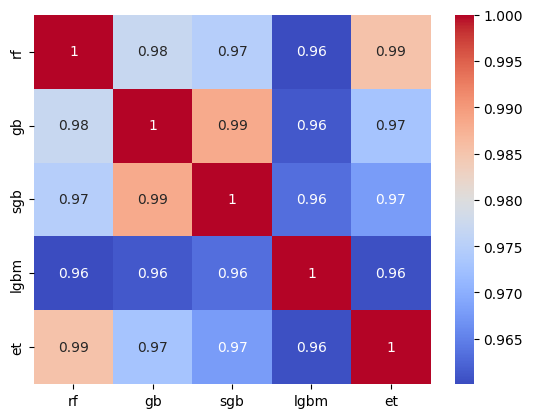

In [49]:
# 모델 수정
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
et = ExtraTreesRegressor(random_state=42)

# 각 모델에서 예측한 결과값을 변수로 갖는 데이터프레임 생성
pred_df = pd.DataFrame({
        "rf": rf_y_pred,
        "gb": gb_y_pred,
        "sgb": xgb_y_pred,
        "lgbm": lgbm_y_pred,
        "et" : et_y_pred
    })

# 상관 행렬 계산
corr_matrix = pred_df.corr()

# 시각화
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [50]:
# 메타 모델 선정
models = [rf, gb, xgb, lgbm, et]
best_score = float("-inf")
best_model = None

for model in models:
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse = (-1 * score.mean()) ** 0.5
    if rmse > best_score:
        best_score = rmse
        best_model = model

print("best_model :", best_model)

# 앙상블 모델 정의
stack = StackingCVRegressor(regressors=(rf, gb, xgb, lgbm, et),
                            meta_regressor=best_model,
                            cv=KFold(n_splits=5, shuffle=True, random_state=42),
                            use_features_in_secondary=True)

# 앙상블 모델 학습
stack.fit(X_train, y_train)

# 앙상블 모델 예측
y_pred = stack.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
best_model : LGBMRegressor(alpha=3.801094025905494, copy_X=True, fit_intercept=True,
              learning_rate=0.0915022317770625, max_depth=3, max_iter=795,
              n_estimators=500, normalize=False, num_leaves=51, random_state=42,
              solver='svd', tol=0.09085487225686105)


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE: 887725.7037069406
MAE: 356640.4063668281
R-squared: 0.7327957892319727


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


In [51]:
# 앙상블 모델의 하이퍼파라미터 탐색 공간과 목적 함수 정의
def stack_objective(trial):
    params = {
        'meta_regressor__alpha': trial.suggest_float('meta_regressor__alpha', 0.01, 10.0),
        'meta_regressor__fit_intercept': trial.suggest_categorical('meta_regressor__fit_intercept', [True, False]),
        'meta_regressor__normalize': trial.suggest_categorical('meta_regressor__normalize', [True, False]),
        'meta_regressor__copy_X': trial.suggest_categorical('meta_regressor__copy_X', [True, False]),
        'meta_regressor__max_iter': trial.suggest_int('meta_regressor__max_iter', 100, 1000),
        'meta_regressor__tol': trial.suggest_float('meta_regressor__tol', 1e-5, 1e-1),
        'meta_regressor__solver': trial.suggest_categorical('meta_regressor__solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    }
    stack.set_params(**params)
    score = np.sqrt(-cross_val_score(stack, X_train, y_train, scoring='neg_mean_squared_error', cv=5))
    return score.mean()

# 앙상블 모델의 하이퍼파라미터 최적화
stack_params = optimize_model(stack_objective, n_trials=100)

[I 2023-05-11 13:18:56,687] A new study created in memory with name: no-name-af408048-7e75-4627-9be5-311248c5877a
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in para

In [ ]:
# 최적의 하이퍼 파라미터 적용 후 학습 및 예측
stack.set_params(**stack_params)
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

# 평가지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


RMSE: 894079.1362167897
MAE: 361313.1292394851
R-squared: 0.72895735359082


In [ ]:
# X_train, X_test 스케일링
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# y_train, y_test 스케일링
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).flatten()

In [ ]:
# 앙상블 모델 학습
stack.fit(X_train_scaled, y_train_scaled)

# 앙상블 모델 예측
y_pred = stack.predict(X_test_scaled)

# 평가지표 계산
rmse = mean_squared_error(y_test_scaled, y_pred, squared=False)
mae = mean_absolute_error(y_test_scaled, y_pred)
r2 = r2_score(y_test_scaled, y_pred)

# 평가지표 출력
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795
[LightGBM] [Warning] Unknown parameter: solver
[LightGBM] [Warning] Unknown parameter: fit_intercept
[LightGBM] [Warning] Unknown parameter: normalize
[LightGBM] [Warning] Unknown parameter: copy_X
[LightGBM] [Warning] Unknown parameter: tol
[LightGBM] [Warning] num_iterations is set=795, max_iter=795 will be ignored. Current value: num_iterations=795


c:\Users\user\anaconda3\envs\DACON-AI\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `max_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


RMSE: 0.047629749090319126
MAE: 0.01974565221447965
R-squared: 0.7613950902078808
